<a href="https://colab.research.google.com/github/greygrease/Melanoma-Classifier/blob/main/Melanoma_Classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Jan  5 10:40:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Drive and Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_path = '/content/gdrive/MyDrive/kaggle_dataset/Skin cancer ISIC /Train'
test_path = '/content/gdrive/MyDrive/kaggle_dataset/Skin cancer ISIC /Test'

In [ ]:
import pathlib
train_dir = pathlib.Path(train_path)
test_dir  = pathlib.Path(test_path)
train_dir, test_dir

(PosixPath('/content/gdrive/MyDrive/kaggle_dataset/Skin cancer ISIC /Train'),
 PosixPath('/content/gdrive/MyDrive/kaggle_dataset/Skin cancer ISIC /Test'))

## Visualize Data

In [ ]:
# Count number of images in each set.
img_train = list(train_dir.glob('*/*.jpg'))
img_test = list(test_dir.glob('*/*.jpg'))
img_count_train = len(list(train_dir.glob('*/*.jpg')))
img_count_test  = len(list(test_dir.glob('*/*.jpg')))
print('{} train images'.format(img_count_train))
print('{}  test  images'.format(img_count_test))

img_train[0], img_test[0]

2239 train images
118  test  images


(PosixPath('/content/gdrive/MyDrive/kaggle_dataset/Skin cancer ISIC /Train/melanoma/ISIC_0000143.jpg'),
 PosixPath('/content/gdrive/MyDrive/kaggle_dataset/Skin cancer ISIC /Test/vascular lesion/ISIC_0024402.jpg'))

In [ ]:
# Plot random images from the dataset

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  target_folder = target_dir + '/' + target_class
  random_image = random.sample(os.listdir(target_folder), 1) # os.listdir() method in python is used to get the list of all files and directories in the specified directory.

  print(f'Image Name: {random_image[0]}')
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')
  return img

Image Name: ISIC_0000036.jpg


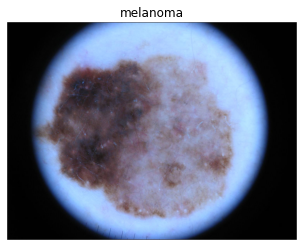

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir="/content/gdrive/MyDrive/kaggle_dataset/Skin cancer ISIC /Test",
                        target_class="melanoma")

## Image Preprocessing

### Image Augmentation


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range            = 100,
    zoom_range                = 10,
    horizontal_flip           = True,
    vertical_flip             = True,
    height_shift_range        = 10,
    width_shift_range         = 10,
    shear_range               = 5.0,
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',                          
)

test_datagen = ImageDataGenerator(rescale = 1/255.)

IMG_SIZE = (244, 244)
BATCH_SIZE = 16

# Train_data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = IMG_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = IMG_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle = True)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [ ]:
dir(train_generator)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_set_index_array',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_indices',
 'class_mode',
 'classes',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'keep_aspect_ratio',
 'labels',
 'lock',
 'n',
 'next',
 'num_classes',
 'on_epoch_end',
 'reset',
 'sample_weight',
 'samples',
 'save_format',
 'save_prefix',

In [ ]:
train_generator.labels

array([0, 0, 0, ..., 8, 8, 8], dtype=int32)

In [ ]:
train_generator, test_generator

(<keras.preprocessing.image.DirectoryIterator at 0x7f96383bc7f0>,
 <keras.preprocessing.image.DirectoryIterator at 0x7f96383bc820>)

## Create feature_extractor

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

feature_extractor = tf.keras.applications.EfficientNetB0(include_top = False,
                                                      input_shape = IMG_SIZE +(3,))
for layer in feature_extractor.layers:
  layer.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
for layer in feature_extractor.layers[:5]:
  print(layer.trainable)

False
False
False
False
False


In [ ]:
feature_extractor.summary() # Check if trainable parameters is 0

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 244, 244, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 244, 244, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 244, 244, 3)  0           ['normalization[0][0

## Get Feature vector from Feature Extractor


In [ ]:
# Get Train Feature Vector

X_train = feature_extractor.predict(train_generator)

140/140 [==============================] - 70s 489ms/step


In [ ]:
print(f'''
Lenght X_train: {len(X_train)}
SHape X_train: {X_train.shape}''')


Lenght X_train: 2239
SHape X_train: (2239, 8, 8, 1280)


In [ ]:
X_train[:3]

array([[[[-0.23646809, -0.1823909 , -0.27704486, ..., -0.23443298,
          -0.19135614,  0.45765632],
         [-0.13685168, -0.18223824, -0.2767402 , ..., -0.25699493,
          -0.16368058,  0.19302753],
         [-0.13327843, -0.1446071 , -0.23607174, ..., -0.24136695,
          -0.16115925,  0.0671019 ],
         ...,
         [-0.14196208, -0.14757769, -0.24192838, ..., -0.23893605,
          -0.1620943 ,  0.06754238],
         [-0.15318835, -0.17293355, -0.2775066 , ..., -0.24297255,
          -0.15310368,  0.17487633],
         [-0.25570744, -0.1837453 , -0.27822387, ..., -0.23920907,
          -0.19192564,  0.50020427]],

        [[-0.18106523, -0.15049772, -0.27671826, ..., -0.21344467,
          -0.11038171,  0.42714328],
         [-0.11371599, -0.12861782, -0.26550865, ..., -0.24234371,
          -0.08395082, -0.10204473],
         [-0.10066222, -0.10667762, -0.22565317, ..., -0.22267628,
          -0.08581211, -0.20909514],
         ...,
         [-0.10920049, -0.10906168

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_train[:3]

array([[-0.23646809, -0.1823909 , -0.27704486, ...,  0.6475195 ,
         3.791099  ,  1.2270839 ],
       [-0.2357233 , -0.18255919, -0.2770312 , ...,  0.63563627,
         3.7930129 ,  1.2244401 ],
       [-0.23636484, -0.18243194, -0.27704334, ...,  0.6431462 ,
         3.7912838 ,  1.2280173 ]], dtype=float32)

In [ ]:
print(f'''
Lenght X_train: {len(X_train)}
Shape X_train after Reshaping: {X_train.shape}''')


Lenght X_train: 2239
Shape X_train after Reshaping: (2239, 81920)


In [ ]:
# Get Test Feature Vector
X_test = feature_extractor.predict(test_generator)

8/8 [==============================] - 8s 984ms/step


In [ ]:
print(f'''
Lenght X_test: {len(X_test)}
SHape X_test: {X_test.shape}''')


Lenght X_test: 118
SHape X_test: (118, 8, 8, 1280)


In [ ]:
X_test[:3]

array([[[[-0.23710385, -0.18243295, -0.27714622, ..., -0.2341094 ,
          -0.1913547 ,  0.46180475],
         [-0.13759156, -0.18196681, -0.2766303 , ..., -0.25647587,
          -0.16347693,  0.19529195],
         [-0.13405867, -0.14457856, -0.23557772, ..., -0.241119  ,
          -0.16116819,  0.06959592],
         ...,
         [-0.14336994, -0.14754452, -0.24146315, ..., -0.2381349 ,
          -0.16201617,  0.06720586],
         [-0.15417685, -0.17272165, -0.27746376, ..., -0.2425147 ,
          -0.15280473,  0.17512569],
         [-0.25623545, -0.18354046, -0.2782243 , ..., -0.23912632,
          -0.19194485,  0.50048405]],

        [[-0.18169622, -0.15045762, -0.2765985 , ..., -0.21325463,
          -0.11036238,  0.43093213],
         [-0.11447478, -0.12850605, -0.26518106, ..., -0.24188165,
          -0.08386023, -0.10064666],
         [-0.10132787, -0.10663561, -0.22495084, ..., -0.22251219,
          -0.08586597, -0.20823866],
         ...,
         [-0.1102752 , -0.10911921

In [ ]:
X_test = X_test.reshape(X_test.shape[0], -1)
X_test[:3]

array([[-0.23710385, -0.18243295, -0.27714622, ...,  0.6485522 ,
         3.790148  ,  1.2345017 ],
       [-0.2367574 , -0.18252976, -0.2770692 , ...,  0.658665  ,
         3.813988  ,  1.2390907 ],
       [-0.23366721, -0.1827239 , -0.2764721 , ...,  0.6461195 ,
         3.7964578 ,  1.2228386 ]], dtype=float32)

In [ ]:
print(f'''
Lenght X_test: {len(X_test)}
SHape X_test Reshaping: {X_test.shape}''')


Lenght X_test: 118
SHape X_test Reshaping: (118, 81920)


### Extract Labels from Image Dataset# 

In [ ]:
train_generator.class_indices.keys()

dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])

In [ ]:
# Get train labels

y_train = tf.one_hot(train_generator.labels, depth = 9)
y_train

<tf.Tensor: shape=(2239, 9), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [ ]:
# Get test labels

y_test = tf.one_hot(test_generator.labels, depth = 9)
y_test

<tf.Tensor: shape=(118, 9), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(2239, 2239, 118, 118)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2239, 81920), TensorShape([2239, 9]), (118, 81920), TensorShape([118, 9]))

## Create RandomForestClassifer and fit train data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 20, random_state = 42)

RF_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=42)

In [ ]:
RF_preds = RF_model.predict(X_test)

In [ ]:
RF_preds[-5:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
len(RF_preds), len(y_test)

(118, 118)

In [ ]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y_test, RF_preds))

Accuracy: 0.0
